In [1]:
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
	sys.path.insert(0, project_root)

from src.twsbm import *
from src.models.beta import *
from src.models.lognorm import *

import numpy as np
import pandas as pd
import os, pickle

def collect_aris(models, transforms, N):
	records = []
	for model in models:
		for i in range(N):
			#A, Z, W = model.sample(i)
			A, Z = model.sample(i)
			row = {
				"model":	model.name,
				"ρ":		model.ρ,
				"π":		model.π,
				"sample":	i,
				model.param_string:	getattr(model, model.param_string),
			}

			X_list = []
			max_gĈ_embed, ARI_argmax_gĈ_embed = -np.inf, None
			for j, t in enumerate(transforms):
				I = TWSBM(A = t(A), 
			  			  Z = Z,
						  model = model,
						  transformation = t)
				row[f't{j}'] = I.ARI
				X_list.append(I.X_A)
				if I.gĈ_embed > max_gĈ_embed:
					max_gĈ_embed = I.gĈ_embed
					ARI_argmax_gĈ_embed = I.ARI

			row["Max Ĉ"] = ARI_argmax_gĈ_embed

			X_stacked = np.concatenate(X_list, axis=1)
			GMM       = TWSBM.fit_gmm(X_stacked, K=2, q_outliers=0)
			Z_hat, *_ = TWSBM.get_gmm_estimates(GMM, X_stacked)
			row["Stacked"] = ARI(Z, Z_hat)

			records.append(row)

	df = pd.DataFrame.from_records(records)
	# reorder columns so transforms appear in order
	cols = ["model", "ρ", "π", models[0].param_string, "sample"]
	cols += [f't{j}' for j, _ in enumerate(transforms)] + ["Max Ĉ"] + ["Stacked"]
	return df[cols]

def flattened_grid(xmin, xmax, ymin, ymax, N, order='C'):
	xs = np.linspace(xmin, xmax, N)
	ys = np.linspace(ymin, ymax, N)
	X, Y = np.meshgrid(xs, ys, indexing='xy')
	return list(zip(X.ravel(order=order), Y.ravel(order=order))) #type: ignore

def get_stats(df, transforms):
	t_cols = [f"t{i}" for i in range(len(transforms))]
	
	df["Max"]    = df[t_cols].max(axis=1)
	df["Median"] = df[t_cols].median(axis=1)
	df["Mean"]   = df[t_cols].mean(axis=1)
	
	result = df[["Max", "Mean", "Median", "Max Ĉ", "Stacked"]].mean()
	return result

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_heatmap(m_class, stats_dict):
	"""
	Affiche une heatmap des ARI pour une classe de modèle donnée,
	avec :
	  - ligne de séparation après la métrique 'Max'
	  - valeurs 'Max' en gras
	  - dégradé rouge→blanc→vert basé sur (métrique − Max)
	"""

	stats_dict = stats_dict[m_class]

	len_models = stats_dict['#models']
	n = stats_dict['n']
	K = stats_dict['K']
	baseline_ARI = stats_dict['Baseline']

	# 1) récupération des stats
	model_stats = stats_dict['transforms']

	# 2) ordre fixe des familles et des métriques
	families = list(model_stats.keys())
	metrics  = ["Max", "Max Ĉ", "Stacked", "Mean", "Median"]

	# 3) matrice des valeurs originales (5 × N familles)
	orig_data = np.array([
		[ model_stats[fam][met] for fam in families ]
		for met in metrics
	], dtype=float)

	# 4) calcul du delta = valeur − Max (Max row deviendra 0)
	#    broadcast : orig_data[0, :] est la ligne 'Max'
	diff_data = orig_data - orig_data[0, :]

	# 5) colormap rouge→blanc→vert centrée sur 0
	cmap = LinearSegmentedColormap.from_list("red_white_green", ["red", "white", "green"])
	max_abs = np.max(np.abs(diff_data))

	# 6) plot
	fig, ax = plt.subplots(figsize=(8, 6))
	im = ax.imshow(diff_data,
				   cmap=cmap,
				   vmin=-max_abs,
				   vmax= max_abs,
				   aspect="auto")

	# 7) ticks & labels
	ax.set_xticks(np.arange(len(families)))
	ax.set_xticklabels(families, rotation=45, ha="right")
	ax.set_yticks(np.arange(len(metrics)))
	ax.set_yticklabels(metrics)

	# 8) annotation des cellules (valeurs originales) et mise en gras pour 'Max'
	for i, met in enumerate(metrics):
		for j, fam in enumerate(families):
			weight = 'bold' if met == "Max" else 'normal'
			ax.text(j, i,
					f"{orig_data[i, j]:.3f}",
					ha="center", va="center",
					fontweight=weight)

	# 9) ligne horizontale sép. après 'Max'
	ax.axhline(y=0.5, color='black', linewidth=2)

	# 10) titre et colorbar
	ax.set_title(f"ARI heatmap for: {m_class.name} (#models = {len_models})\n" + 
			     f"n = {n}, K = {K}, Baseline ARI = {baseline_ARI:.3f}\n")
	ax.set_xlabel("Transform Families")
	cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
	cbar.set_label("Metric − Max", rotation=270, labelpad=15)

	plt.tight_layout()
	plt.show()

In [ ]:
from scipy.stats import uniform

qtl_10_transforms = [QuantileTransform(q) for q in np.linspace(0.01, 0.5, 10)]
qtl_05_transforms = [QuantileTransform(q) for q in np.linspace(0.01, 0.5, 5)]
pow_10_transforms = [PowerTransform(p) for p in np.linspace(0.5, 2, 10)]
pow_05_transforms = [PowerTransform(p) for p in np.linspace(0.5, 2, 5)]
classical_transforms  = [IdentityTransform(), OppositeTransform(), LogTransform(), RankTransform(), QuantileTransform(q=0.1), PowerTransform(γ=1.41)]

TRANSFORMS = {'classical' : classical_transforms,
			  'qtl_10' : qtl_10_transforms,
			  'qtl_05' : qtl_05_transforms,
			  'pow_10' : pow_10_transforms,
			  'pow_05' : pow_05_transforms}

beta_models, lognorm_models = [], []
μ = LognormWSBM.mu_for_quantile_at_zero(σ=1, quantile=0.99)

for ρ in [0.1, 
		  0.25, 
		  0.5,
		  ]:
	for π in [0.1, 
		   	  0.25, 
			  0.5,
			  ]:
		for p in flattened_grid(0.1, 0.9, 0.1, 0.9, 3):

			beta_models.append(BetaWSBM(K=2, 
							   ρ=ρ,
							   #G=[uniform, uniform],
							   π=np.array([π, 1-π]), 
							   n=1000, 
							   α=np.array([[p[0], p[1]], [p[1], 1]])))
			
			lognorm_models.append(LognormWSBM(K=2, 
								ρ=ρ,
								#G=[uniform, uniform],
								π=np.array([π, 1-π]), 
								n=1000, 
								Σ=np.array([[p[0], p[1]], [p[1], 1]]),
								μ=μ))

In [ ]:
df_dict = {BetaWSBM : {}, 
		   LognormWSBM : {}}
N = 2

for m_class, models in zip([BetaWSBM, LognormWSBM], [beta_models, lognorm_models]):
	print(f"Collecting ARIs for {m_class.name} transforms...")
	df_dict[m_class]['#models'] = len(models) * N
	df_dict[m_class]['n'] = models[0].n
	df_dict[m_class]['K'] = models[0].K

	samples = [(model.sample(i), model) for model in models for i in range(N)]
	df_dict[m_class]['Baseline'] = np.mean([TWSBM(*sample, model=model).ARI for sample, model in samples])

	df_dict[m_class]['transforms'] = {}
	for id, transforms in TRANSFORMS.items():
		print(f"Collecting ARIs for {id} transforms...")
		df_dict[m_class]['transforms'][id] = collect_aris(models, transforms, N=N)

# point to your data/ directory
data_dir = os.path.join(project_root, 'data/processed/synthetic_graphs')
os.makedirs(data_dir, exist_ok=True)

# choose a filename
fn = os.path.join(data_dir, 'df_dict.pkl')

# dump it
with open(fn, 'wb') as f:
	pickle.dump(df_dict, f)

print(f"Saved df_dict → {fn}")

Saved df_dict → c:\Users\Nicol\Documents\EPFL\MA6\Project\Improving_Spectral_Clustering_through_Chernoff_Guided_Edge_WeightTransformations\data/processed/synthetic_graphs\df_dict.pkl


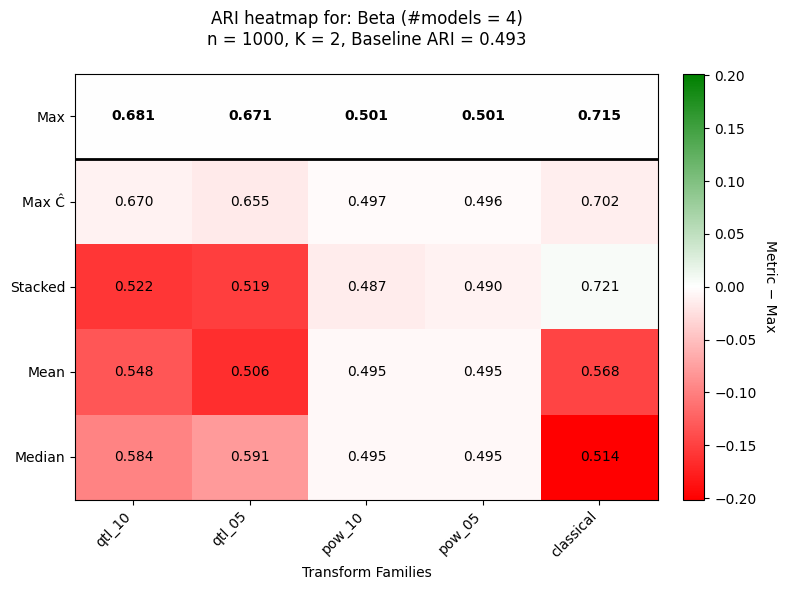

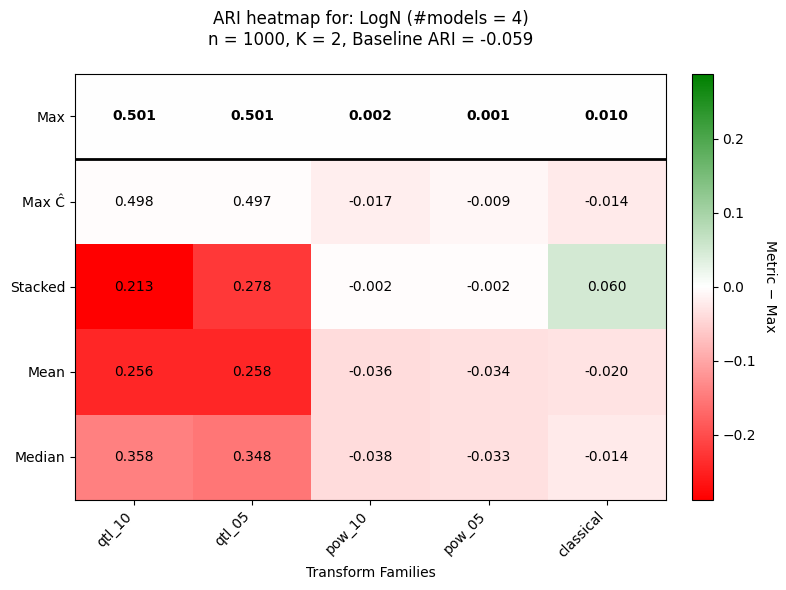

In [7]:
data_dir = os.path.join(project_root, 'data/processed/synthetic_graphs')
fn = os.path.join(data_dir, 'df_dict.pkl')
with open(fn, 'rb') as f:
	df_dict = pickle.load(f)

stats_dict = {BetaWSBM : {}, 
		   LognormWSBM : {}}

for m_class in [BetaWSBM, LognormWSBM]:
	print(f"Collecting stats for {m_class.name} transforms...")
	stats_dict[m_class]['transforms'] = {}
	for id, transforms in TRANSFORMS.items():
		print(f"Collecting stats for {id} transforms...")
		stats_dict[m_class]['transforms'][id] = get_stats(df_dict[m_class]['transforms'][id], transforms)
		stats_dict[m_class]['#models'] = df_dict[m_class]['#models']
		stats_dict[m_class]['Baseline'] = df_dict[m_class]['Baseline']
		stats_dict[m_class]['n'] = df_dict[m_class]['n']
		stats_dict[m_class]['K'] = df_dict[m_class]['K']

plot_heatmap(BetaWSBM, stats_dict)
plot_heatmap(LognormWSBM, stats_dict)